<a href="https://colab.research.google.com/github/Paras-Ghime/IIIT_Hyderabad_Paras_Ghime/blob/main/Paras_Ghime_Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-07 17:39:48--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.23MB/s    in 0.3s    

2025-02-07 17:39:49 (3.23 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Optimized function to get genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    # Explode genres for faster filtering
    movies_exploded = movies.assign(genres=movies['genres'].str.split('|')).explode('genres')

    # Filter only the required genres
    movies_filtered = movies_exploded[movies_exploded['genres'].isin(genres)]

    # Merge ratings with filtered movies
    merged = ratings.merge(movies_filtered[['movieId', 'genres']], on='movieId')

    # Compute average rating per user for each genre
    genre_ratings = merged.groupby(['userId', 'genres'])['rating'].mean().unstack().round(2)

    # Rename columns
    genre_ratings.columns = column_names

    return genre_ratings

# Calculate the average rating of Romance and Sci-Fi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])

# Display results
genre_ratings.head()


,avg_romance_rating,avg_scifi_rating
userId,,
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,userId,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


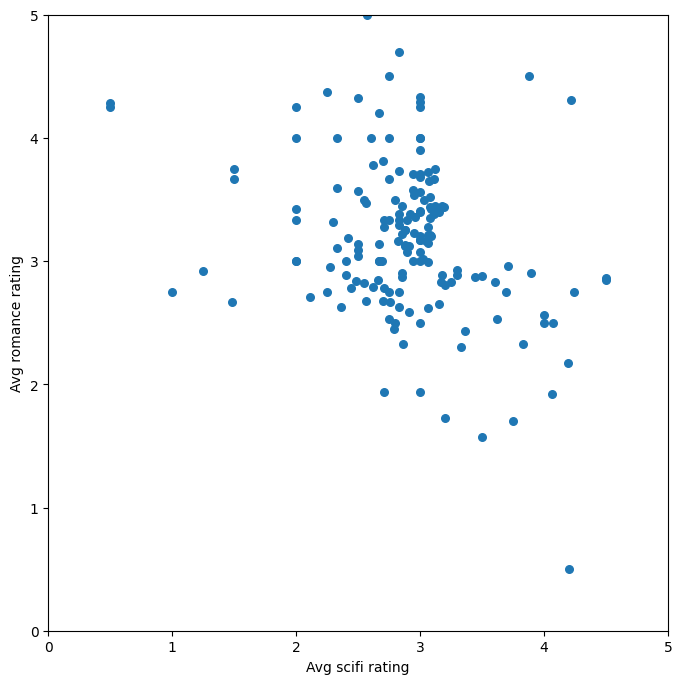

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

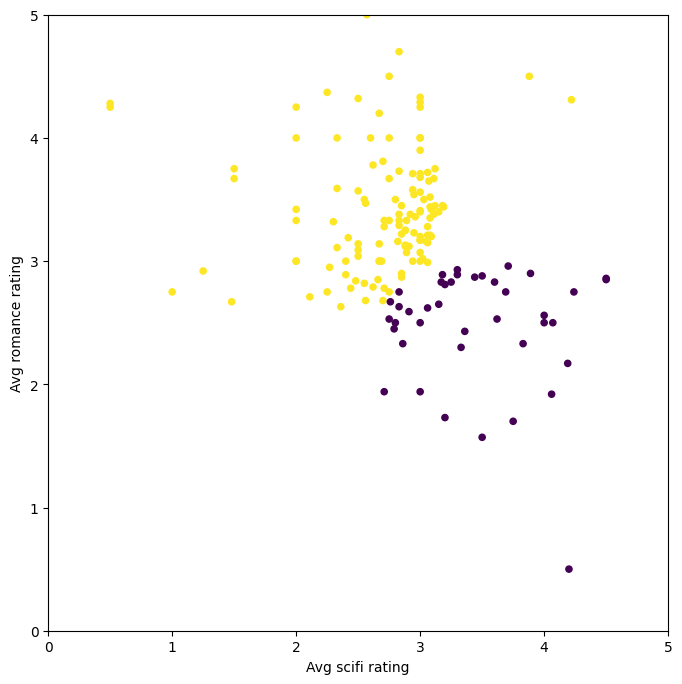

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

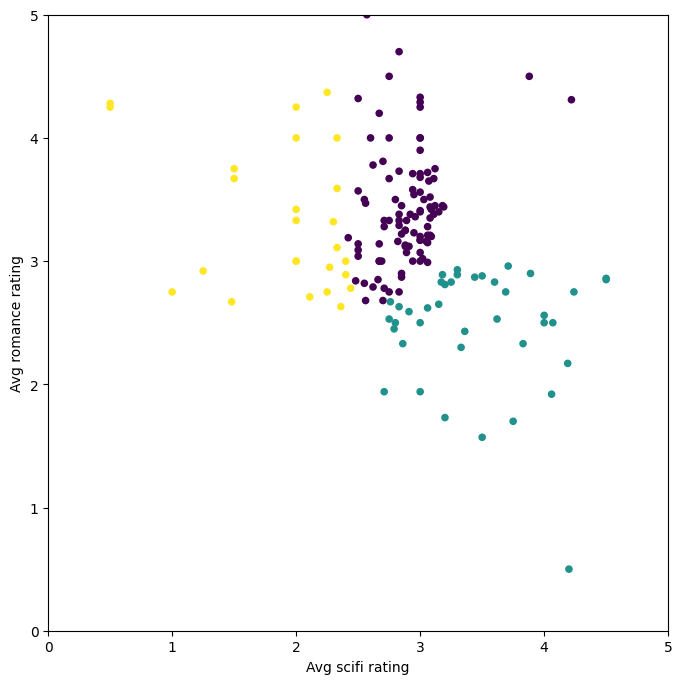

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


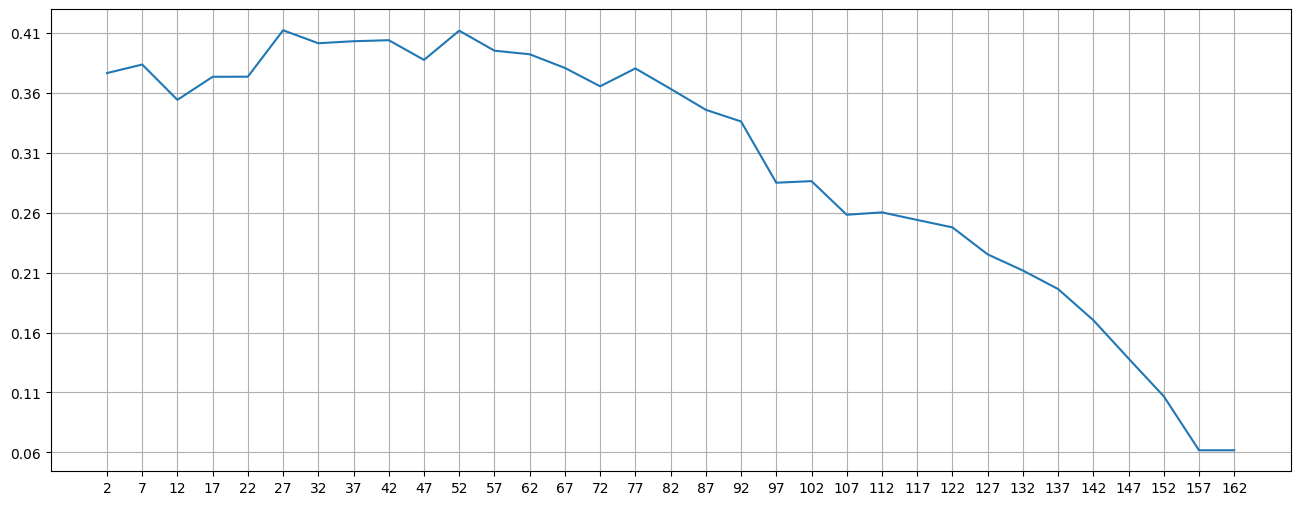

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



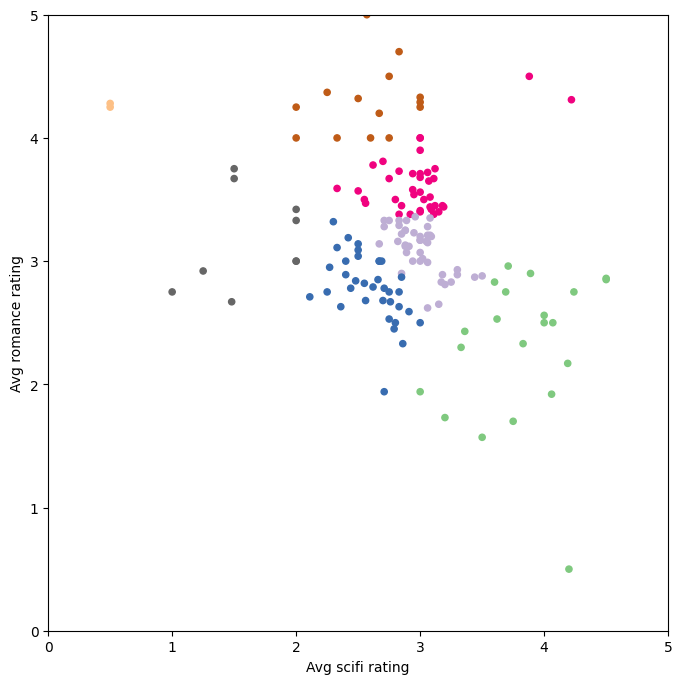

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  152


,userId,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,3.57,0.50,4.20
1,5,3.11,3.09,2.50
2,7,3.26,2.65,3.15
3,9,3.12,3.17,3.00
4,19,2.73,2.68,2.56


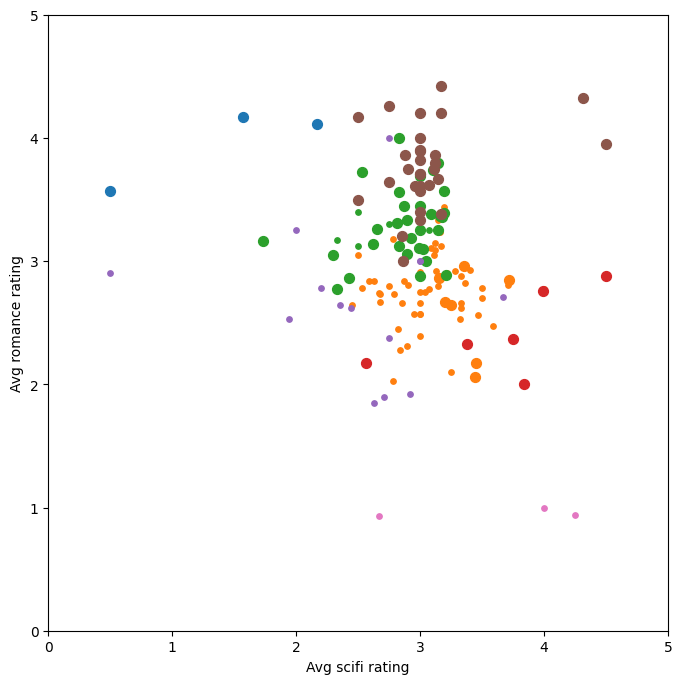

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

Optimal number of clusters: 2


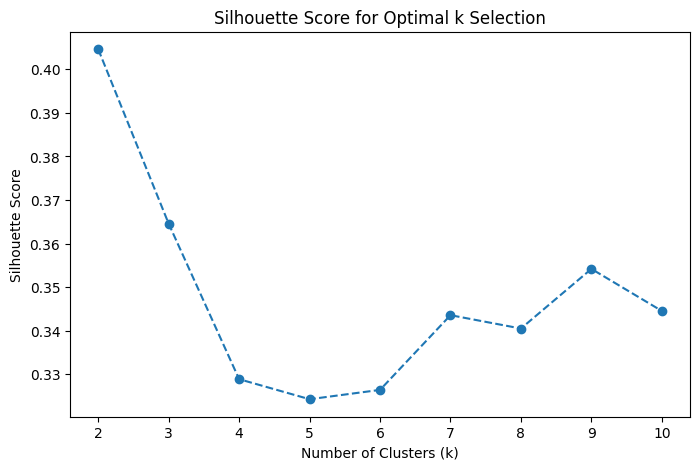

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Assuming 'genre_ratings' is your dataset with 3 features
X = genre_ratings.copy()

# Handle NaN values by replacing them with the mean of each column
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
X_imputed = imputer.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Try different values of k
silhouette_scores = []
k_values = range(2, 11)  # Testing k from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

# Find the best k
best_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {best_k}")

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k Selection')
plt.show()


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
import pandas as pd

# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count ratings per movie
    count_row = user_movie_ratings.count().to_frame().T  # Convert to DataFrame for concatenation

    # 2- Append count as a new row
    user_movie_ratings = pd.concat([user_movie_ratings, count_row], ignore_index=True)

    # 3- Sort movies based on the count of ratings (last row)
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)

    # 4- Drop the last row (count row) after sorting
    user_movie_ratings_sorted = user_movie_ratings_sorted.iloc[:-1, :]

    # 5- Slice the top `max_number_of_movies`
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]

    return most_rated_movies

# Define function to get the users who rate the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)  # Count non-null ratings
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)  # Sort by num_ratings
    most_rated_movies = most_rated_movies.iloc[:n_users, :]  # Select top `n_users`
    most_rated_movies = most_rated_movies.drop(columns=['num_ratings'])  # Drop helper column

    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)

    return most_rated_movies

# Choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('Dataset dimensions:', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


Dataset dimensions: (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
413                    5.0                               5.0   
589                    5.0                               4.5   
473                    3.0                               5.0   
479                    5.0                               5.0   
67                     3.5                               3.0   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
413                    5.0                               4.0   
589                    4.5                               3.5   
473                    4.0                               4.5   
479                    4.0                               4.5   
67                     2.0                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
413                   5.0                                        5.0   
589                   4.0                                

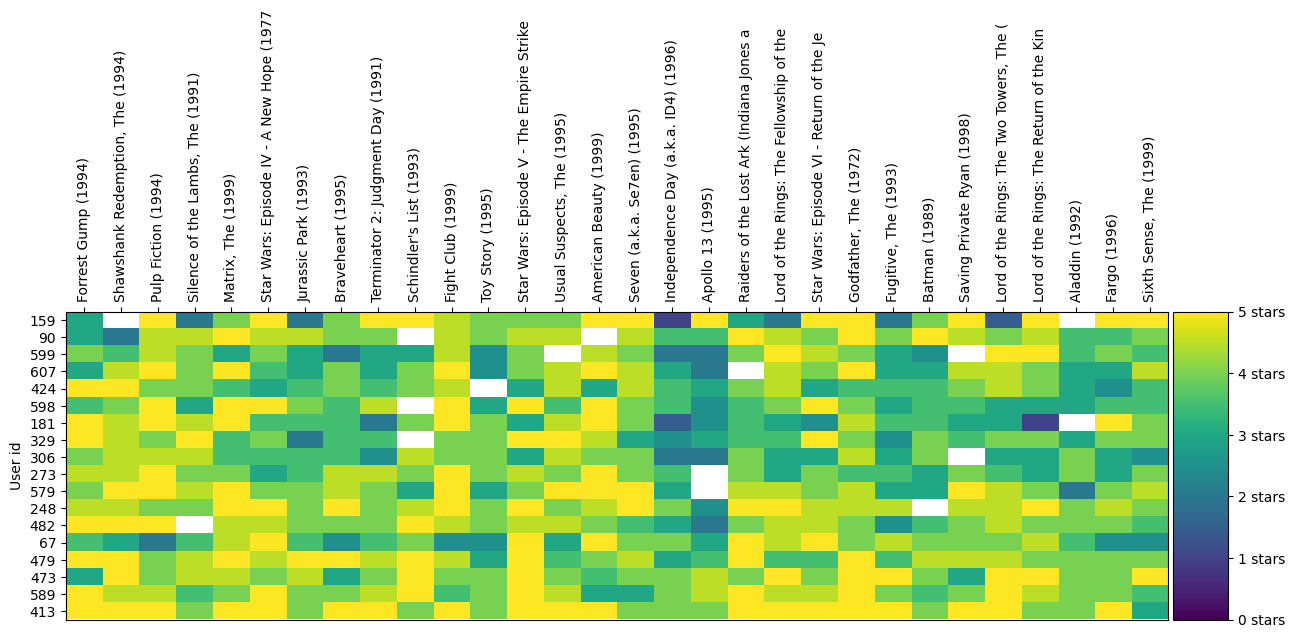

In [18]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [19]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [20]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [21]:
from sklearn.cluster import KMeans
import pandas as pd

# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='lloyd', random_state=42, n_init=10).fit_predict(sparse_ratings)

# Select the most rated movies and cluster users
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(),
                       pd.DataFrame({'group': predictions})], axis=1)

# draw_movie_clusters(clustered, max_users, max_movies)  # Uncomment if function exists


### Predictions and Recommendation

     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
104                  3.5                               5.0   
297                  3.0                               3.5   
317                  4.5                               4.0   
559                  3.5                               NaN   

     Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
104                  5.0                               4.5   
297                  4.5                               NaN   
317                  4.5                               4.0   
559                  4.0                               4.0   

     Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
104                 4.0                                        4.0   
297                 4.0                                        4.0   
317                 3.5                                        3.0   
559                 4.5                                        4.0   

     Jurassic Park (1993)  

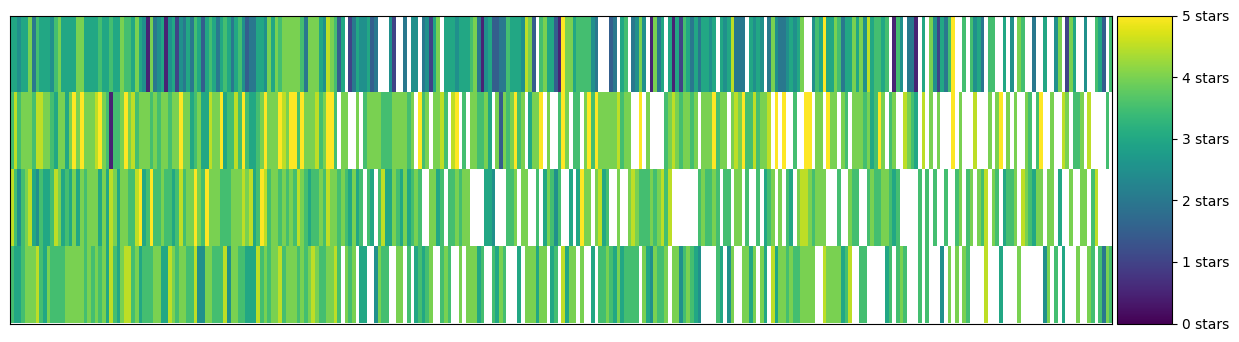

In [22]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [23]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.0

In [24]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
Forrest Gump (1994),3.625
Limitless (2011),3.500
Meet the Parents (2000),2.875
Moonrise Kingdom (2012),3.500
Inglourious Basterds (2009),3.750
Spirited Away (Sen to Chihiro no kamikakushi) (2001),4.125
Resident Evil (2002),3.125
Sin City (2005),3.750
300 (2007),3.625
Harry Potter and the Prisoner of Azkaban (2004),3.250


In [25]:
cluster

,Forrest Gump (1994),Limitless (2011),Meet the Parents (2000),Moonrise Kingdom (2012),Inglourious Basterds (2009),Spirited Away (Sen to Chihiro no kamikakushi) (2001),Resident Evil (2002),Sin City (2005),300 (2007),Harry Potter and the Prisoner of Azkaban (2004),...,Taken (2008),Blue Velvet (1986),Adaptation (2002),Black Swan (2010),Mulan (1998),Dazed and Confused (1993),Ghostbusters (a.k.a. Ghost Busters) (1984),Shanghai Noon (2000),8 Mile (2002),Rise of the Planet of the Apes (2011)
1,3.0,3.0,2.5,3.0,3.0,4.0,2.0,3.5,3.0,3.0,...,NaN,NaN,2.5,NaN,NaN,3.5,3.0,1.5,NaN,3.5
0,3.5,4.5,3.5,4.0,4.0,4.0,3.5,4.5,4.5,4.0,...,3.5,4.0,NaN,4.5,NaN,NaN,NaN,NaN,3.5,NaN
2,4.5,3.5,2.5,3.5,4.0,4.5,3.0,2.5,3.5,3.0,...,NaN,4.0,4.0,NaN,3.5,4.5,NaN,NaN,NaN,NaN
3,3.5,3.0,3.0,3.5,4.0,4.0,4.0,4.5,3.5,3.0,...,4.0,NaN,NaN,4.0,3.5,NaN,3.5,2.0,4.0,3.5


In [26]:
# Pick a user ID from the dataset
user_id = 7

# Ensure user_id exists in the dataset
if user_id in cluster.index:
    # Get all this user's ratings
    user_2_ratings = cluster.loc[user_id, :]

    # Which movies did they not rate?
    user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]

    # What are the ratings of these movies the user did not rate?
    avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:, 0]

    # Let's sort by rating so the highest-rated movies are presented first
    recommended_movies = avg_ratings.sort_values(ascending=False)[:20]

    print(recommended_movies)
else:
    print(f"User ID {user_id} not found in dataset!")


User ID 7 not found in dataset!


## Using Collaborative Filtering (With fast.ai)

In [27]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00


In [28]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [29]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [30]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [31]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [32]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [33]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [34]:
dls.show_batch()

,user,title,rating
0,347,Mission: Impossible (1996),4
1,334,Annie Hall (1977),4
2,378,Alice in Wonderland (1951),4
3,675,Six Degrees of Separation (1993),4
4,359,Return of the Jedi (1983),5
5,347,"Jungle Book, The (1994)",3
6,239,Sophie's Choice (1982),5
7,871,Raiders of the Lost Ark (1981),5
8,660,Mars Attacks! (1996),3
9,504,Father of the Bride Part II (1995),3


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [35]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [36]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.879813,0.960637,00:18
1,0.684956,0.897969,00:08
2,0.520535,0.873045,00:07
3,0.460215,0.857662,00:07
4,0.441519,0.855097,00:07


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [37]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [38]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [39]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [40]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.4002),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2779), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2773), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2654),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2638), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.2541), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2468), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2363), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2285), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2277), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2215), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2196), 'Keys to Tulsa (1997)', 2.24),
 (tensor(-0.2143), 'Stuart Saves His Family (1995)', 2.125),
 (tensor(-0.2133), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2129), 'Tales from the Hoo

Or the ones with the best bias:

In [41]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5886), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5679), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5577), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5550), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5540), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5458), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5349), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5303), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5168), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4979), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4789), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4748), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4737), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4672),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
  4.252577319587629),
 (tensor(0.4668), 'Star Wars (1977)', 4.3584905660377355)

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [42]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [43]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [44]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [45]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1086), 'Godfather, The (1972)'),
 (tensor(1.0474), 'Wrong Trousers, The (1993)'),
 (tensor(1.0332), 'Third Man, The (1949)'),
 (tensor(1.0206), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(0.9972), 'Fargo (1996)'),
 (tensor(0.9925), 'Chinatown (1974)'),
 (tensor(0.9864), 'Lawrence of Arabia (1962)'),
 (tensor(0.9779), 'Casablanca (1942)'),
 (tensor(0.9672), 'Dead Man Walking (1995)'),
 (tensor(0.9594), 'When We Were Kings (1996)')]

And the worst:

In [46]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1809), 'Home Alone 3 (1997)'),
 (tensor(-1.1646), 'Grease 2 (1982)'),
 (tensor(-1.1391), 'Jungle2Jungle (1997)'),
 (tensor(-1.1098), 'Leave It to Beaver (1997)'),
 (tensor(-1.0942), 'Mr. Wrong (1996)'),
 (tensor(-1.0749), "McHale's Navy (1997)"),
 (tensor(-1.0505), 'Shadow Conspiracy (1997)'),
 (tensor(-1.0471), 'Beautician and the Beast, The (1997)'),
 (tensor(-1.0428), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0406), 'Children of the Corn: The Gathering (1996)')]

Same thing for our second dimension:

In [47]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.7938), 'Heavenly Creatures (1994)'),
 (tensor(0.7861), 'Pallbearer, The (1996)'),
 (tensor(0.7636), 'Jude (1996)'),
 (tensor(0.7631), 'Brazil (1985)'),
 (tensor(0.7587), 'Crow: City of Angels, The (1996)'),
 (tensor(0.7581), 'Lost Highway (1997)'),
 (tensor(0.7353), 'Stuart Saves His Family (1995)'),
 (tensor(0.7329), 'Dead Man (1995)'),
 (tensor(0.7295), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7274), 'Clockwork Orange, A (1971)')]

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2676), 'Braveheart (1995)'),
 (tensor(-1.2458), 'Titanic (1997)'),
 (tensor(-0.9759), 'Miracle on 34th Street (1994)'),
 (tensor(-0.9573), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.8983), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(-0.8891), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8891), 'Field of Dreams (1989)'),
 (tensor(-0.8864), 'Phenomenon (1996)'),
 (tensor(-0.8847), "It's a Wonderful Life (1946)"),
 (tensor(-0.8632), 'Time to Kill, A (1996)')]

And we can even plot the movies according to their scores on those dimensions:

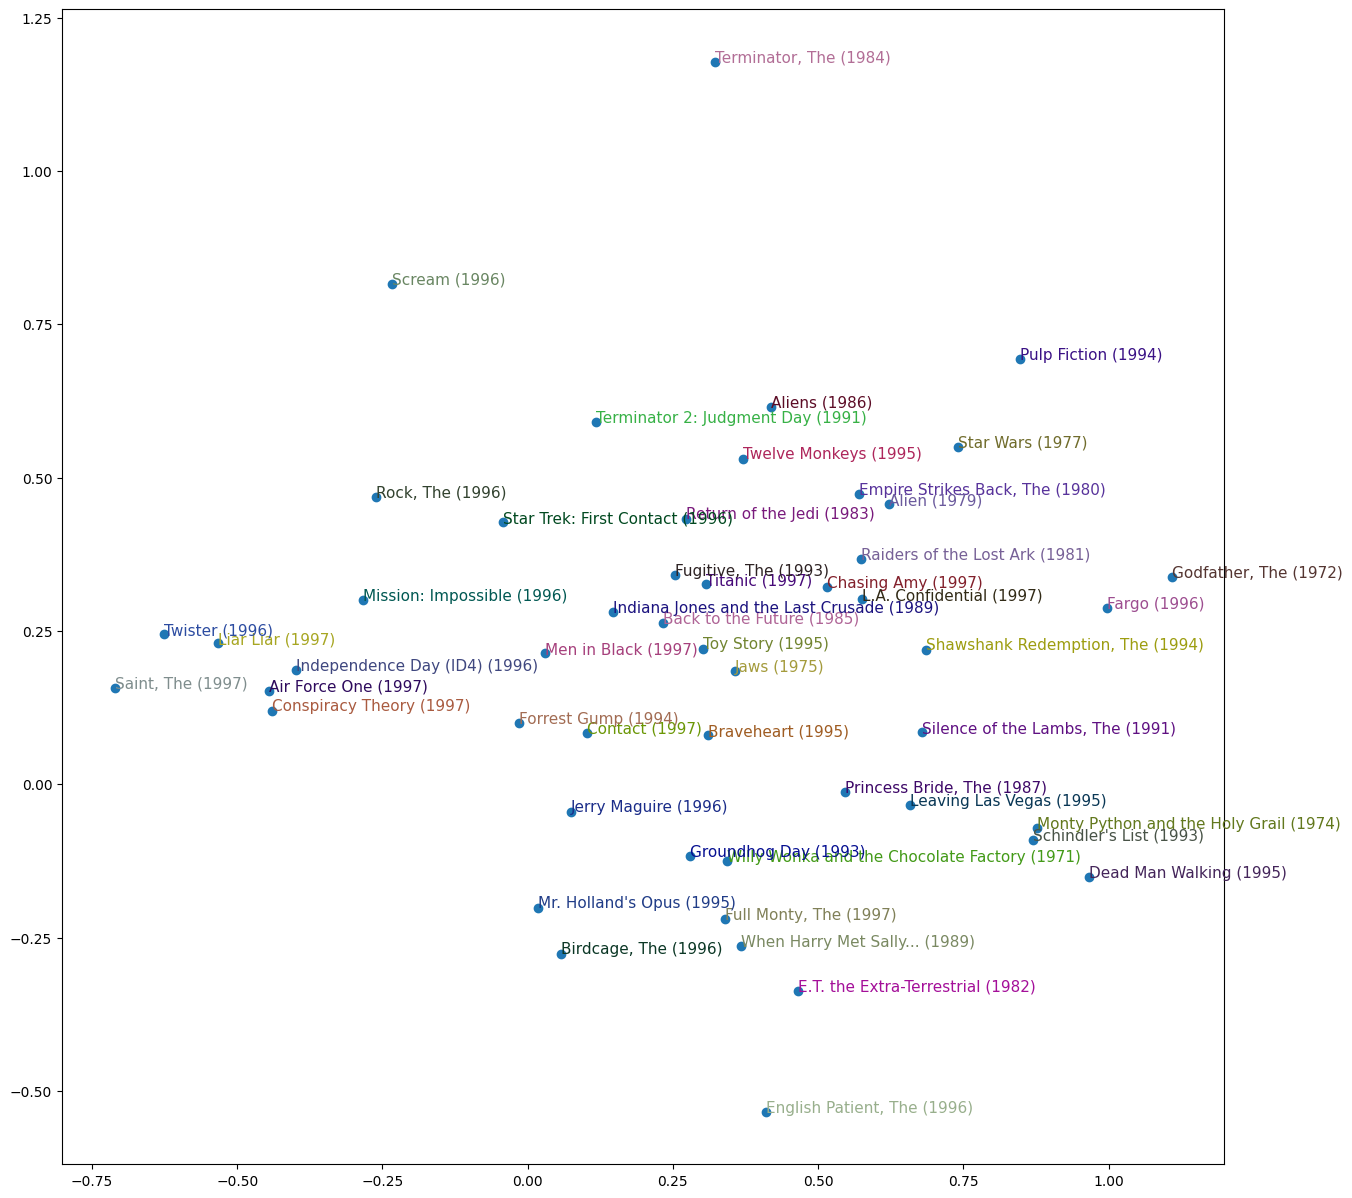

In [50]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [58]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505182 sha256=cf6423ac805ff382008a53fecf994e741021911dfaf8a203c9fcbbf4fa03daed
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [59]:
# Import required libraries
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Sample data (if ratings.csv is not available)
sample_data = {
    "userId": [1, 1, 1, 2, 2, 3, 3, 4, 4, 5],
    "movieId": [101, 102, 103, 101, 104, 102, 105, 103, 106, 107],
    "rating": [5, 4, 3, 5, 4, 2, 5, 3, 4, 5]
}

# Create a DataFrame
ratings = pd.DataFrame(sample_data)

# Define a Reader object
reader = Reader(rating_scale=(1, 5))

# Load the dataset
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Use SVD (Singular Value Decomposition) model
svd = SVD(n_factors=50, n_epochs=20, verbose=True)

# Perform cross-validation
cross_validate(svd, data, cv=5, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'test_rmse': array([1.88782338, 1.23345552, 0.91882125, 0.15028405, 0.88604084]),
 'test_mae': array([1.8056115 , 1.23334305, 0.74029489, 0.13701056, 0.8825388 ]),
 'fit_time': (0.005843400955200195,
  0.00046634674072265625,
  0.0004220008850097656,
  0.00041413307189941406,
  0.0004687309265136719),
 'test_time': (8.559226989746094e-05,
  3.910064697265625e-05,
  3.337860107421875e-05,
  6.222724914550781e-05,
  3.337860107421875e-05)}